In [19]:
import numpy as np
import os
import matplotlib.pyplot as plt
import energyflow as ef
import energyflow.archs
from energyflow.archs import PFN
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Layer, concatenate
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import BatchNormalization

from scipy.stats import zscore

plt.rc('font', size=20)
plt.rcParams["font.family"] = "serif"

os.environ["CUDA_VISIBLE_DEVICES"] = "1" # pick a number < 4 on ML4HEP
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
#These are the same datasets from the OmniFold paper https://arxiv.org/abs/1911.09107.  More detail at https://energyflow.network/docs/datasets/.
#Pythia and Herwig are two generators; one will be treated here as the "simulation" and one as "data".
datasets = {'Pythia26': ef.zjets_delphes.load('Pythia26', num_data=1000000),
            'Herwig': ef.zjets_delphes.load('Herwig', num_data=1000000)}

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [20]:
w_true = zscore(datasets['Pythia26']['gen_widths']) #gen = particle level
w_reco = zscore(datasets['Pythia26']['sim_widths']) #sim = detector level
w_true_alt = zscore(datasets['Herwig']['gen_widths'])
w_reco_alt = zscore(datasets['Herwig']['sim_widths'])

In [21]:
initializer = tf.keras.initializers.RandomUniform(minval=-5., maxval=5.)
n = 1

class MyLayer(Layer):

    def __init__(self, myc, **kwargs):
        self.myinit = myc
        super(MyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self._lambda = self.add_weight(name='lambda', 
                                    shape=(n,),
                                    initializer=tf.keras.initializers.Constant(self.myinit), 
                                    trainable=True)
        
        super(MyLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        #return tf.exp(self._lambda1 * x + self._lambda0)
        return tf.exp(sum([self._lambda[i]* x**(i+1) for i in range(n)]))

In [22]:
def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss

    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred)/weights_1 +
                         (1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)

def weighted_binary_crossentropy_GAN(y_true, y_pred):
    weights = tf.gather(y_pred, [1], axis=1) # event weights
    y_pred = tf.gather(y_pred, [0], axis=1) # actual y_pred for loss

    weights_1 = K.sum(y_true*weights)
    weights_0 = K.sum((1-y_true)*weights)

    #tf.print("weights",weights_0,weights_1)

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = weights * ((1 - y_true) * K.log(1 - y_pred)/weights_0)
    return K.mean(t_loss)

In [28]:
xvals_1 = np.concatenate([w_true_alt,w_true])
yvals_1 = np.concatenate([np.ones(len(w_true_alt)),np.zeros(len(w_true))])

xvals_2 = np.concatenate([w_reco_alt,w_reco])
yvals_2 = np.concatenate([np.ones(len(w_reco_alt)),np.zeros(len(w_reco))])

X_train_1, X_test_1, Y_train_1, Y_test_1, X_train_2, X_test_2, Y_train_2, Y_test_2 = train_test_split(xvals_1, 
                                                                                    yvals_1, xvals_2, yvals_2)


N = 3
n = 1
errors_weighted = np.zeros((N, N))
errors_unweighted = np.zeros((N, N))

myc = 0.1
mymodel_inputtest = Input(shape=(1,))


    
while n < N:
    print(f"{n = }")
    
    mymodel_test = MyLayer(myc)(mymodel_inputtest)
    model_generator = Model(mymodel_inputtest, mymodel_test)

    inputs_disc = Input((1, ))
    hidden_layer_1_disc = Dense(50, activation='relu')(inputs_disc)
    hidden_layer_2_disc = Dense(50, activation='relu')(hidden_layer_1_disc)
    hidden_layer_3_disc = Dense(50, activation='relu')(hidden_layer_2_disc)
    outputs_disc = Dense(1, activation='sigmoid')(hidden_layer_3_disc)
    model_discrimantor = Model(inputs=inputs_disc, outputs=outputs_disc)

    model_discrimantor.compile(loss=weighted_binary_crossentropy, optimizer='adam')

    model_discrimantor.trainable = False
    mymodel_gan = Input(shape=(1,))
    gan_model = Model(inputs=mymodel_gan,outputs=concatenate([model_discrimantor(mymodel_gan),model_generator(mymodel_gan)]))


    gan_model.compile(loss=weighted_binary_crossentropy_GAN, optimizer='adam')

    n_epochs = 20
    n_batch = 128*10
    n_batches = len(X_train_1) // n_batch

    for i in range(n_epochs):
        for j in range(n_batches):
            X_batch = X_train_1[j*n_batch:(j+1)*n_batch]
            Y_batch = Y_train_1[j*n_batch:(j+1)*n_batch]
            W_batch = model_generator(X_batch)
            W_batch = np.array(W_batch).flatten()
            W_batch[Y_batch==1] = 1
            #W_batch[Y_batch==0] = 1

            Y_batch_2 = np.stack((Y_batch, W_batch), axis=1)

            model_discrimantor.train_on_batch(X_batch, Y_batch_2)

            gan_model.train_on_batch(X_batch[Y_batch==0],np.zeros(len(X_batch[Y_batch==0])))
            
        mylambda = np.array(model_generator.layers[-1].get_weights())
        print("on epoch=",i, mylambda)

    arr = np.array([mylambda[:, k]*w_true**(k+1) for k in range(n)])
    exponent = np.exp(np.sum(arr, axis=0))
    weights_1 = np.concatenate([np.ones(len(w_true_alt)),exponent*len(w_true_alt)/np.sum(exponent)])

    X_train_1, X_test_1, Y_train_1, Y_test_1, X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_1, w_test_1 = train_test_split(xvals_1, 
                                                                                    yvals_1, xvals_2, yvals_2, weights_1)

    #data, simulation w/o weights, weighted simulation
    for i in range(n):
        print("Moment ", i+1)
        print(np.mean(X_test_2[Y_test_2==1]**(i+1)),np.mean(X_test_2[Y_test_2==0]**(i+1)),np.average(X_test_2[Y_test_2==0]**(i+1),weights=w_test_1[Y_test_2==0]))
    errors_weighted[:, n] = [(np.average(X_test_2[Y_test_2==0]**(i+1),weights=w_test_1[Y_test_2==0]) - np.mean(X_test_2[Y_test_2==1]**(i+1)))/np.average(X_test_2[Y_test_2==0]**(i+1),weights=w_test_1[Y_test_2==0]) for i in range(N)]
    errors_unweighted[:, n] = [(np.mean(X_test_2[Y_test_2==0]**(i+1)) - np.mean(X_test_2[Y_test_2==1]**(i+1)))/np.mean(X_test_2[Y_test_2==0]**(i+1)) for i in range(N)]
    n += 1
    print("\n\n\n")

n = 1
on epoch= 0 [[0.03537255]]
on epoch= 1 [[0.03684805]]
on epoch= 2 [[0.03957772]]
on epoch= 3 [[0.0409363]]
on epoch= 4 [[0.04227283]]
on epoch= 5 [[0.04365083]]
on epoch= 6 [[0.04441427]]
on epoch= 7 [[0.04430298]]
on epoch= 8 [[0.04353614]]
on epoch= 9 [[0.04371634]]
on epoch= 10 [[0.04339319]]
on epoch= 11 [[0.04315841]]
on epoch= 12 [[0.04352394]]
on epoch= 13 [[0.04432455]]
on epoch= 14 [[0.04398193]]
on epoch= 15 [[0.0432761]]
on epoch= 16 [[0.04354683]]
on epoch= 17 [[0.04422856]]
on epoch= 18 [[0.04315031]]
on epoch= 19 [[0.04220404]]
Moment  1
-0.0012424713199665294 0.0026797030788592515 0.041596654606448874




n = 2
on epoch= 0 [[ 0.09425951 -0.0343384 ]]
on epoch= 1 [[ 0.0955181  -0.03725559]]
on epoch= 2 [[ 0.09313111 -0.0381955 ]]
on epoch= 3 [[ 0.09236959 -0.03842672]]
on epoch= 4 [[ 0.09072974 -0.03810237]]
on epoch= 5 [[ 0.09019952 -0.03797472]]
on epoch= 6 [[ 0.09004646 -0.04024401]]
on epoch= 7 [[ 0.08898629 -0.03871094]]
on epoch= 8 [[ 0.08987124 -0.03763933]]


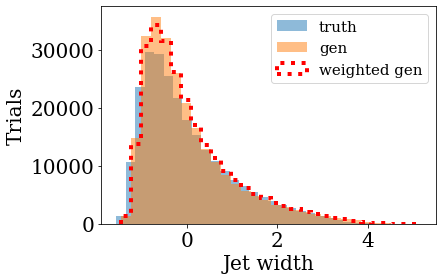

In [29]:
nbins = 30
_,_,_=plt.hist(X_test_2[Y_test_2==1],bins=nbins,alpha=0.5,label="truth")
_,_,_=plt.hist(X_test_2[Y_test_2==0],bins=nbins,alpha=0.5,label="gen")
_,_,_=plt.hist(X_test_2[Y_test_2==0],bins=nbins,weights=w_test_1[Y_test_2==0],histtype="step",color="r",ls=":", lw=4,label="weighted gen")
plt.legend(fontsize=15)
plt.xlabel("Jet width")
plt.ylabel("Trials")
plt.savefig("jetexample.pdf", bbox_inches='tight', transparent=True)

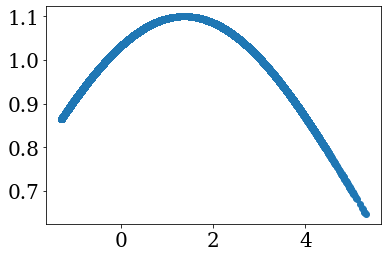

In [30]:
plt.scatter(X_test_1[Y_test_2==0], w_test_1[Y_test_2==0])